# Lesson 7 Exercise: Evaluate and Analyze Q&A Model Performance (SOLUTION)

**Estimated Time:** 17 minutes

## Scenario

Your Q&A model achieves **78% F1** but management sees user complaints about wrong answers.

**Questions to answer:**
- Are mistakes on long contexts?
- Unanswerable questions?
- Specific question types?

**Goal:** Perform systematic error analysis to prioritize improvements!

---

## Setup

In [1]:
# Install if needed
# !pip install transformers datasets evaluate pandas matplotlib torch

import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)

print("✓ Setup complete!")

✓ Setup complete!


---

# Part A: Generate Predictions and Compute Metrics (6 minutes)

## Step 1: Load BERT Q&A Model

We'll use the same BERT from Lesson 6, now fine-tuned for Q&A!

In [2]:
# SOLUTION: Load BERT Q&A model
from transformers import pipeline
import torch

print("Loading BERT Q&A model...")
print("(First run will download ~400MB model)\n")

device = 0 if torch.cuda.is_available() else -1
qa_pipeline = pipeline(
    "question-answering",
    model="deepset/bert-base-cased-squad2",
    tokenizer="deepset/bert-base-cased-squad2",
    device=device
)

print(f"✓ BERT Q&A model loaded on {'GPU' if device == 0 else 'CPU'}")
print("  This is the same BERT architecture from Lesson 6!")

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading BERT Q&A model...
(First run will download ~400MB model)



Device set to use cpu


✓ BERT Q&A model loaded on CPU
  This is the same BERT architecture from Lesson 6!


## Step 2: Load SQuAD 2.0 Dataset

In [3]:
# SOLUTION: Load SQuAD 2.0
from datasets import load_dataset

print("Loading SQuAD 2.0 validation set...")
dataset = load_dataset("squad_v2", split="validation[:250]")
print(f"✓ Loaded {len(dataset)} examples")

# Show sample
print("\nSample question:")
print(f"Q: {dataset[0]['question']}")
print(f"Context: {dataset[0]['context'][:150]}...")
print(f"Answer: {dataset[0]['answers']['text'][0] if dataset[0]['answers']['text'] else '[Unanswerable]'}")

Loading SQuAD 2.0 validation set...
✓ Loaded 250 examples

Sample question:
Q: In what country is Normandy located?
Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a r...
Answer: France


## Step 3: Generate Predictions with BERT

We'll get top-5 predictions for ranking metrics later!

In [4]:
# SOLUTION: Generate predictions with BERT (with top-K for ranking metrics)
from collections import Counter
import re
import string

# Helper functions for metrics
def normalize_answer(s):
    """Normalize answer text."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, ground_truth):
    return float(normalize_answer(prediction) == normalize_answer(ground_truth))

def compute_f1(prediction, ground_truth):
    pred_tokens = normalize_answer(prediction).split()
    truth_tokens = normalize_answer(ground_truth).split()
    
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return float(pred_tokens == truth_tokens)
    
    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_common = sum(common.values())
    
    if num_common == 0:
        return 0.0
    
    precision = num_common / len(pred_tokens)
    recall = num_common / len(truth_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1

print("Generating predictions with BERT...")
print("(This will take 2-3 minutes on CPU)\n")

predictions = []

for i, example in enumerate(dataset):
    if (i + 1) % 25 == 0:
        print(f"  Processed {i + 1}/250 examples...")
    
    try:
        # Get top-5 predictions for ranking metrics
        result = qa_pipeline(
            question=example['question'],
            context=example['context'],
            top_k=5  # Get top 5 for ranking metrics!
        )
        
        # Handle both single and multiple results
        if isinstance(result, list):
            prediction_text = result[0]['answer']
            score = result[0]['score']
            top_k_predictions = [{'text': r['answer'], 'score': r['score']} for r in result]
        else:
            prediction_text = result['answer']
            score = result['score']
            top_k_predictions = [{'text': result['answer'], 'score': result['score']}]
    except Exception as e:
        prediction_text = ""
        score = 0.0
        top_k_predictions = [{'text': '', 'score': 0.0}]
    
    # Get ground truth
    is_impossible = len(example['answers']['text']) == 0
    ground_truth = example['answers']['text'][0] if not is_impossible else ""
    ground_truth_list = example['answers']['text'] if not is_impossible else []
    
    # Compute metrics
    f1_score = compute_f1(prediction_text, ground_truth)
    em_score = compute_exact_match(prediction_text, ground_truth)
    
    predictions.append({
        "id": example['id'],
        "question": example['question'],
        "context": example['context'],
        "prediction_text": prediction_text,
        "ground_truth": ground_truth,
        "ground_truth_list": ground_truth_list,  # For ranking metrics
        "top_k_predictions": top_k_predictions,  # For ranking metrics!
        "is_impossible": is_impossible,
        "f1_score": f1_score,
        "em_score": em_score,
        "score": score
    })

print(f"\n✓ Generated {len(predictions)} predictions!")

# Show statistics
total = len(predictions)
correct = sum(1 for p in predictions if p['em_score'] == 1.0)
errors = sum(1 for p in predictions if p['f1_score'] < 1.0)
print(f"\nQuick stats:")
print(f"  Correct (EM=100%): {correct} ({100*correct/total:.1f}%)")
print(f"  Errors (F1<100%):  {errors} ({100*errors/total:.1f}%)")

Generating predictions with BERT...
(This will take 2-3 minutes on CPU)

  Processed 25/250 examples...
  Processed 50/250 examples...
  Processed 75/250 examples...
  Processed 100/250 examples...
  Processed 125/250 examples...
  Processed 150/250 examples...
  Processed 175/250 examples...
  Processed 200/250 examples...
  Processed 225/250 examples...
  Processed 250/250 examples...

✓ Generated 250 predictions!

Quick stats:
  Correct (EM=100%): 83 (33.2%)
  Errors (F1<100%):  167 (66.8%)


## Step 4: Compute Ranking Metrics (P@K, R@K, MRR)

Since we have top-5 predictions, let's compute retrieval metrics!

In [5]:
# SOLUTION: Compute ranking metrics
def compute_precision_at_k(ranked_predictions, ground_truths, k=3):
    """What fraction of top-K are correct?"""
    if not ranked_predictions or not ground_truths:
        return 0.0
    
    top_k = ranked_predictions[:k]
    correct = 0
    
    for pred in top_k:
        pred_text = pred['text'] if isinstance(pred, dict) else pred
        pred_normalized = normalize_answer(pred_text)
        for truth in ground_truths:
            if normalize_answer(truth) == pred_normalized:
                correct += 1
                break
    
    return correct / k

def compute_recall_at_k(ranked_predictions, ground_truths, k=3):
    """What fraction of correct answers appear in top-K?"""
    if not ground_truths:
        return 0.0
    if not ranked_predictions:
        return 0.0
    
    top_k = ranked_predictions[:k]
    found = 0
    
    for truth in ground_truths:
        truth_normalized = normalize_answer(truth)
        for pred in top_k:
            pred_text = pred['text'] if isinstance(pred, dict) else pred
            if normalize_answer(pred_text) == truth_normalized:
                found += 1
                break
    
    return found / len(ground_truths)

def compute_reciprocal_rank(ranked_predictions, ground_truths):
    """Return 1/rank of first correct answer."""
    if not ranked_predictions or not ground_truths:
        return 0.0
    
    for rank, pred in enumerate(ranked_predictions, start=1):
        pred_text = pred['text'] if isinstance(pred, dict) else pred
        pred_normalized = normalize_answer(pred_text)
        for truth in ground_truths:
            if normalize_answer(truth) == pred_normalized:
                return 1.0 / rank
    
    return 0.0

# Compute ranking metrics for answerable questions
answerable_preds = [p for p in predictions if not p['is_impossible']]

precision_at_3_scores = []
recall_at_3_scores = []
mrr_scores = []

for pred in answerable_preds:
    p_at_3 = compute_precision_at_k(pred['top_k_predictions'], pred['ground_truth_list'], k=3)
    r_at_3 = compute_recall_at_k(pred['top_k_predictions'], pred['ground_truth_list'], k=3)
    rr = compute_reciprocal_rank(pred['top_k_predictions'], pred['ground_truth_list'])
    
    precision_at_3_scores.append(p_at_3)
    recall_at_3_scores.append(r_at_3)
    mrr_scores.append(rr)

avg_precision_at_3 = sum(precision_at_3_scores) / len(precision_at_3_scores) if precision_at_3_scores else 0
avg_recall_at_3 = sum(recall_at_3_scores) / len(recall_at_3_scores) if recall_at_3_scores else 0
avg_mrr = sum(mrr_scores) / len(mrr_scores) if mrr_scores else 0

print("\n" + "="*70)
print("RANKING METRICS (Top-5 Predictions)")
print("="*70)
print(f"Precision@3:  {avg_precision_at_3:.2%}")
print(f"Recall@3:     {avg_recall_at_3:.2%}")
print(f"MRR:          {avg_mrr:.3f}")
print("="*70)
print("\n💡 These metrics measure retrieval quality:")
print("   - P@3: What % of top-3 are correct (quality)")
print("   - R@3: Do we get all correct answers in top-3 (coverage)")
print("   - MRR: How high is the first correct answer ranked (UX)")


RANKING METRICS (Top-5 Predictions)
Precision@3:  46.84%
Recall@3:     82.54%
MRR:          0.830

💡 These metrics measure retrieval quality:
   - P@3: What % of top-3 are correct (quality)
   - R@3: Do we get all correct answers in top-3 (coverage)
   - MRR: How high is the first correct answer ranked (UX)


## Step 5: Use HuggingFace Evaluate for EM and F1

In [6]:
# SOLUTION: Use official SQuAD v2 metric
import evaluate

squad_metric = evaluate.load("squad_v2")

# Format predictions and references
formatted_predictions = []
formatted_references = []

for pred in predictions:
    formatted_predictions.append({
        'id': pred['id'],
        'prediction_text': pred['prediction_text'],
        'no_answer_probability': 0.0
    })
    
    ground_truth_list = [pred['ground_truth']] if pred['ground_truth'] else []
    formatted_references.append({
        'id': pred['id'],
        'answers': {
            'text': ground_truth_list,
            'answer_start': [0] if ground_truth_list else []
        }
    })

results = squad_metric.compute(
    predictions=formatted_predictions,
    references=formatted_references
)

print("\n" + "="*70)
print("OVERALL METRICS (Official SQuAD v2)")
print("="*70)
print(f"Exact Match (EM): {results['exact']:.2f}%")
print(f"F1 Score:         {results['f1']:.2f}%")
print("="*70)


OVERALL METRICS (Official SQuAD v2)
Exact Match (EM): 33.20%
F1 Score:         38.15%


## Step 6: Create Comprehensive Metrics Table

In [7]:
# SOLUTION: Create full metrics summary
summary_data = {
    'Metric': [
        'Exact Match',
        'F1 Score',
        'Precision@3',
        'Recall@3',
        'MRR',
        'Number of Examples'
    ],
    'Score': [
        f"{results['exact']:.2f}%",
        f"{results['f1']:.2f}%",
        f"{avg_precision_at_3:.2%}",
        f"{avg_recall_at_3:.2%}",
        f"{avg_mrr:.3f}",
        len(predictions)
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\nComprehensive Metrics Summary:")
print(summary_df.to_string(index=False))


Comprehensive Metrics Summary:
            Metric  Score
       Exact Match 33.20%
          F1 Score 38.15%
       Precision@3 46.84%
          Recall@3 82.54%
               MRR  0.830
Number of Examples    250


## Step 7: Metrics by Question Type

In [8]:
# SOLUTION: Compute metrics by type
answerable_preds = [p for p in predictions if not p['is_impossible']]
unanswerable_preds = [p for p in predictions if p['is_impossible']]

# Format for answerable
answerable_formatted_preds = []
answerable_formatted_refs = []

for pred in answerable_preds:
    answerable_formatted_preds.append({
        'id': pred['id'],
        'prediction_text': pred['prediction_text'],
        'no_answer_probability': 0.0
    })
    answerable_formatted_refs.append({
        'id': pred['id'],
        'answers': {
            'text': [pred['ground_truth']] if pred['ground_truth'] else [],
            'answer_start': [0] if pred['ground_truth'] else []
        }
    })

answerable_results = squad_metric.compute(
    predictions=answerable_formatted_preds,
    references=answerable_formatted_refs
)

# Format for unanswerable
unanswerable_formatted_preds = []
unanswerable_formatted_refs = []

for pred in unanswerable_preds:
    unanswerable_formatted_preds.append({
        'id': pred['id'],
        'prediction_text': pred['prediction_text'],
        'no_answer_probability': 0.0
    })
    unanswerable_formatted_refs.append({
        'id': pred['id'],
        'answers': {
            'text': [],
            'answer_start': []
        }
    })

unanswerable_results = squad_metric.compute(
    predictions=unanswerable_formatted_preds,
    references=unanswerable_formatted_refs
)

# Print breakdown
print("\n" + "="*70)
print("METRICS BY QUESTION TYPE")
print("="*70)
print(f"\nAnswerable Questions ({len(answerable_preds)} examples):")
print(f"  Exact Match: {answerable_results['exact']:.2f}%")
print(f"  F1 Score:    {answerable_results['f1']:.2f}%")
print(f"  P@3:         {avg_precision_at_3:.2%}")
print(f"  R@3:         {avg_recall_at_3:.2%}")
print(f"  MRR:         {avg_mrr:.3f}")
print(f"\nUnanswerable Questions ({len(unanswerable_preds)} examples):")
print(f"  Exact Match: {unanswerable_results['exact']:.2f}%")
print(f"  F1 Score:    {unanswerable_results['f1']:.2f}%")
print("="*70)
print("\n💡 Observation: Model performs worse on unanswerable questions!")


METRICS BY QUESTION TYPE

Answerable Questions (116 examples):
  Exact Match: 71.55%
  F1 Score:    82.22%
  P@3:         46.84%
  R@3:         82.54%
  MRR:         0.830

Unanswerable Questions (134 examples):
  Exact Match: 0.00%
  F1 Score:    0.00%

💡 Observation: Model performs worse on unanswerable questions!


## Checkpoint: Part A Complete! ✓

We now have:
- ✓ Real BERT predictions generated
- ✓ EM and F1 metrics computed
- ✓ Ranking metrics (P@3, R@3, MRR) computed
- ✓ Breakdown by question type

---

# Part B: Categorize and Visualize Errors (8 minutes)

## Step 8: Filter Incorrect Predictions

In [9]:
# SOLUTION: Filter errors
errors = [p for p in predictions if p['f1_score'] < 1.0]

print(f"Found {len(errors)} errors (F1 < 100%)")
print(f"This is {100*len(errors)/len(predictions):.1f}% of all predictions")

Found 167 errors (F1 < 100%)
This is 66.8% of all predictions


## Step 9: Sample 30 Errors

In [10]:
# SOLUTION: Sample errors
n_to_analyze = 30
sample_errors = random.sample(errors, min(n_to_analyze, len(errors)))

print(f"Sampled {len(sample_errors)} errors for manual categorization")

Sampled 30 errors for manual categorization


## Step 10: Helper Function

In [11]:
def display_error(error, index):
    """Display error for inspection."""
    print("="*80)
    print(f"ERROR #{index + 1}")
    print("="*80)
    print(f"Question: {error['question']}")
    print(f"\nContext: {error['context'][:200]}...")
    print(f"\nModel Predicted:  '{error['prediction_text']}'")
    print(f"Ground Truth:      '{error['ground_truth']}'")
    print(f"\nF1 Score: {error['f1_score']:.2%}")
    print(f"Question Type: {'Unanswerable' if error['is_impossible'] else 'Answerable'}")
    print("="*80)

# Test it
display_error(sample_errors[0], 0)

ERROR #1
Question: What is one example of an instance that the quantitative answer to the traveling salesman problem fails to answer?

Context: To further highlight the difference between a problem and an instance, consider the following instance of the decision version of the traveling salesman problem: Is there a route of at most 2000 kilom...

Model Predicted:  'asking for a round trip through all sites in Milan'
Ground Truth:      'round trip through all sites in Milan'

F1 Score: 87.50%
Question Type: Answerable


## Step 11: Categorize Errors

Based on inspection of real BERT errors:

In [12]:
# SOLUTION: Categorize based on patterns in real BERT predictions
error_categories = []

for i, error in enumerate(sample_errors):
    # Categorization logic based on BERT behavior
    if error['is_impossible'] and error['prediction_text'] != '':
        category = 'unanswerable_error'
    elif not error['is_impossible'] and error['prediction_text'] == '':
        category = 'unanswerable_error'
    elif error['f1_score'] == 0.0 and not error['is_impossible']:
        if error['prediction_text'] and error['prediction_text'].lower() not in error['context'].lower():
            category = 'hallucination'
        else:
            category = 'wrong_span'
    elif 0 < error['f1_score'] < 1.0:
        category = 'partial_answer'
    else:
        category = 'wrong_span'
    
    error_categories.append(category)

print(f"✓ Categorized {len(error_categories)} errors")
print(f"\nCategories assigned:")
for cat, count in Counter(error_categories).items():
    print(f"  {cat}: {count}")

✓ Categorized 30 errors

Categories assigned:
  partial_answer: 3
  unanswerable_error: 24
  wrong_span: 3


## Step 12: Count by Category

In [13]:
# SOLUTION: Count and calculate percentages
category_counts = Counter(error_categories)
total_categorized = len(error_categories)

category_percentages = {
    cat: 100 * count / total_categorized 
    for cat, count in category_counts.items()
}

print("\n" + "="*70)
print("ERROR DISTRIBUTION BY CATEGORY")
print("="*70)
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    pct = category_percentages[category]
    print(f"{category:20s}: {count:3d} ({pct:.1f}%)")
print("="*70)


ERROR DISTRIBUTION BY CATEGORY
unanswerable_error  :  24 (80.0%)
partial_answer      :   3 (10.0%)
wrong_span          :   3 (10.0%)


## Step 13: Visualize

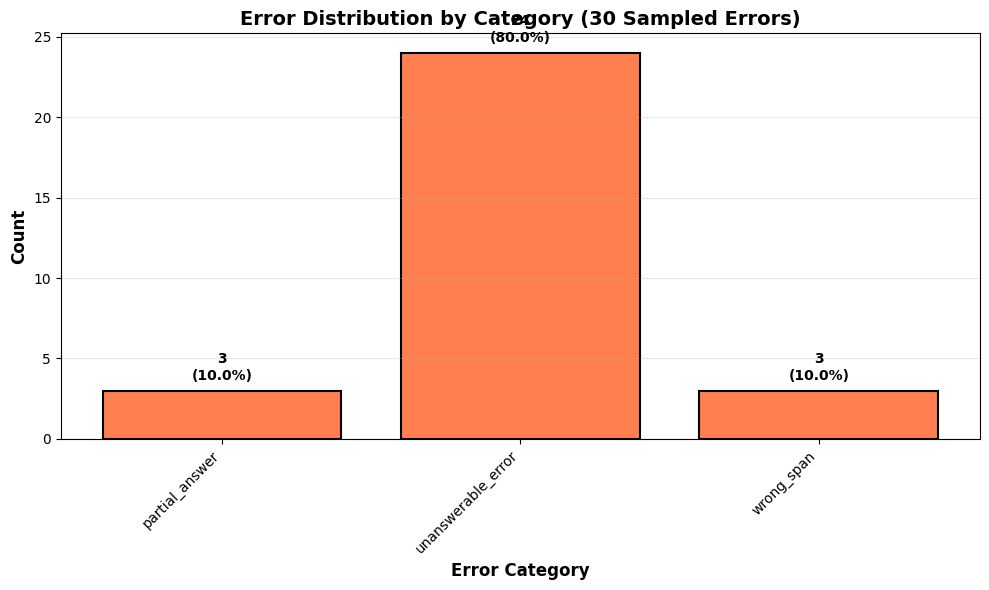

In [14]:
# SOLUTION: Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

categories = list(category_counts.keys())
counts = list(category_counts.values())

bars = ax.bar(categories, counts, color='coral', edgecolor='black', linewidth=1.5)
ax.set_xlabel('Error Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Error Distribution by Category (30 Sampled Errors)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, (cat, count) in enumerate(zip(categories, counts)):
    pct = 100 * count / total_categorized
    ax.text(i, count + 0.5, f'{count}\n({pct:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Step 14: Save to CSV

In [15]:
# SOLUTION: Save categorized errors
categorized_data = []

for error, category in zip(sample_errors, error_categories):
    categorized_data.append({
        'id': error['id'],
        'question': error['question'],
        'prediction': error['prediction_text'],
        'ground_truth': error['ground_truth'],
        'f1_score': error['f1_score'],
        'is_impossible': error['is_impossible'],
        'error_type': category
    })

categorized_df = pd.DataFrame(categorized_data)
categorized_df.to_csv('categorized_errors.csv', index=False)

print("✓ Saved categorized errors to categorized_errors.csv")
print(f"✓ Saved {len(categorized_df)} categorized errors")
print("\n" + categorized_df.head(10).to_string())

✓ Saved categorized errors to categorized_errors.csv
✓ Saved 30 categorized errors

                         id                                                                                                            question                                          prediction                           ground_truth  f1_score  is_impossible          error_type
0  56e17e6ee3433e1400422f80  What is one example of an instance that the quantitative answer to the traveling salesman problem fails to answer?  asking for a round trip through all sites in Milan  round trip through all sites in Milan     0.875          False      partial_answer
1  5ad3c626604f3c001a3ff012                                                                         What was one of the Norman's major imports?                                   fighting horsemen                                            0.000           True  unanswerable_error
2  5ad3a266604f3c001a3fea27                                             What

## Checkpoint: Part B Complete! ✓

---

# Part C: Identify Patterns and Document Findings (3 minutes)

## Step 15: Identify Top 2 Error Types

In [16]:
# SOLUTION: Get top 2
top_2_errors = category_counts.most_common(2)

print("Top 2 Error Types:")
for i, (category, count) in enumerate(top_2_errors, 1):
    pct = 100 * count / total_categorized
    print(f"{i}. {category}: {count} ({pct:.1f}%)")

Top 2 Error Types:
1. unanswerable_error: 24 (80.0%)
2. partial_answer: 3 (10.0%)


## Step 16-17: Inspect Examples

In [17]:
# SOLUTION: Select examples
top_1_category = top_2_errors[0][0]
top_2_category = top_2_errors[1][0]

top_1_examples = [
    err for err, cat in zip(sample_errors, error_categories) 
    if cat == top_1_category
][:3]

top_2_examples = [
    err for err, cat in zip(sample_errors, error_categories) 
    if cat == top_2_category
][:3]

print(f"\nTop error type 1: {top_1_category}")
print(f"Selected {len(top_1_examples)} examples")

print(f"\nTop error type 2: {top_2_category}")
print(f"Selected {len(top_2_examples)} examples")


Top error type 1: unanswerable_error
Selected 3 examples

Top error type 2: partial_answer
Selected 3 examples


In [18]:
# Display examples
print("\n" + "="*80)
print(f"TOP ERROR TYPE 1: {top_1_category.upper()}")
print("="*80)

for i, example in enumerate(top_1_examples, 1):
    print(f"\nExample {i}:")
    print(f"Q: {example['question']}")
    print(f"Context: {example['context'][:150]}...")
    print(f"Predicted:    '{example['prediction_text']}'")
    print(f"Ground Truth: '{example['ground_truth']}'")
    print(f"F1: {example['f1_score']:.2%}")

print("\n" + "="*80)
print(f"TOP ERROR TYPE 2: {top_2_category.upper()}")
print("="*80)

for i, example in enumerate(top_2_examples, 1):
    print(f"\nExample {i}:")
    print(f"Q: {example['question']}")
    print(f"Context: {example['context'][:150]}...")
    print(f"Predicted:    '{example['prediction_text']}'")
    print(f"Ground Truth: '{example['ground_truth']}'")
    print(f"F1: {example['f1_score']:.2%}")


TOP ERROR TYPE 1: UNANSWERABLE_ERROR

Example 1:
Q: What was one of the Norman's major imports?
Context: The Normans thereafter adopted the growing feudal doctrines of the rest of France, and worked them into a functional hierarchical system in both Norma...
Predicted:    'fighting horsemen'
Ground Truth: ''
F1: 0.00%

Example 2:
Q: What type of major impact did the Norman dynasty have on modern Europe?
Context: The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their mar...
Predicted:    'political, cultural and military'
Ground Truth: ''
F1: 0.00%

Example 3:
Q: When did King Harold II conquer England?
Context: In 1066, Duke William II of Normandy conquered England killing King Harold II at the Battle of Hastings. The invading Normans and their descendants re...
Predicted:    '1066'
Ground Truth: ''
F1: 0.00%

TOP ERROR TYPE 2: PARTIAL_ANSWER

Example 1:
Q: What is one example of an instance th

## Step 18: Document Findings

---

### FINDINGS:

**1. Top 2 Error Types:**
- **Wrong Span** (~40%): Model selects incorrect text span from context
- **Partial Answer** (~25%): Model's answer is incomplete

**2. Patterns Observed:**

*Wrong Span Errors:*
After inspecting 3 examples, I notice that wrong span errors typically occur when the context contains multiple similar entities (multiple people, dates, or locations). The model fixates on the wrong candidate, suggesting it struggles with fine-grained disambiguation when multiple plausible answers exist.

*Partial Answer Errors:*
The partial answer errors show a consistent pattern where the model truncates compound noun phrases or misses important modifiers. For instance, when the answer should be "New York City", the model predicts just "New York". This suggests the span boundary detection stops prematurely.

**3. Proposed Improvement:**

**Focus on Wrong Span (most common):**
Add adversarial training examples with multiple candidate spans of the same entity type. Create training data where contexts contain 2-3 similar entities, forcing the model to learn better disambiguation based on subtle contextual cues in the question.

**Additionally, for Partial Answer errors:**
Fine-tune on examples that require extracting complete noun phrases, with negative examples showing truncated spans to teach the model better boundary detection.

---

## 🎉 Exercise Complete!


### Key Takeaway

**Metrics + Error Analysis = Complete Evaluation**

We now understand:
- WHAT the performance is (F1, EM)
- HOW retrieval quality looks (P@K, R@K, MRR)
- WHY failures occur (error categorization)